In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
import torch
from sys import getsizeof
import matplotlib.pyplot as plt
from my_functions import FokkerPlankCalculator, get_pos, get_pos_with_border
from scipy.linalg import expm
from tqdm.notebook import tqdm
import yaml
from pathlib import Path
import pickle

## frist tests

In [2]:
myfpc = FokkerPlankCalculator()

k = 3
tau = 0.3
D = 1e-6
s = np.sqrt(2*D)
max_t = 5
dt = 1e-2 *2
dx = 1e-4

In [3]:
ts = np.arange(0,max_t,dt)
l_data = myfpc.l(k,tau,ts, 40)
1/np.e /k, np.pi/2 /k

(0.12262648039048078, 0.5235987755982988)

In [4]:
#var_old = 2*myfpc.get_v_n(l_data,ts, max_t, s=s)

In [5]:
var = 4*D*np.cumsum(l_data**2) *dt

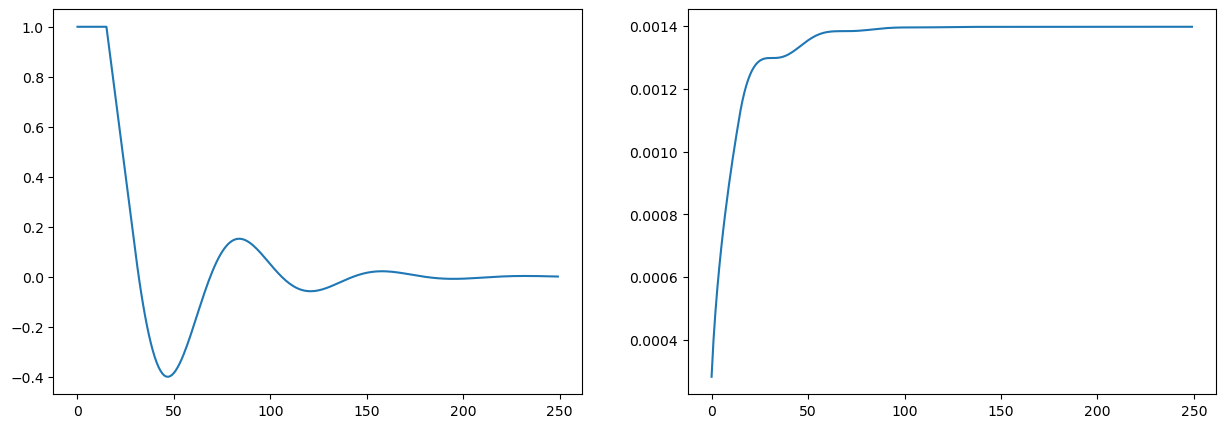

In [6]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(l_data)

plt.subplot(122)
plt.plot(np.sqrt(var))
#plt.plot(var_old)

In [7]:
w_tt = 4*D / np.sqrt(var[:,None]*var[None,:]) *np.stack(
    [[dt*np.sum( (l_data[:,None]*l_data[None,:])[np.arange(t_idx, t_idx-ts_idx-1/2,-1, dtype=int),
                                              np.arange(ts_idx,0-1/2,-1,dtype=int)] if t_idx >= ts_idx else np.nan) 
     for ts_idx in np.arange(0, len(ts))] 
      for t_idx in np.arange(0, len(ts))])

In [8]:
w_tt.shape

(250, 250)

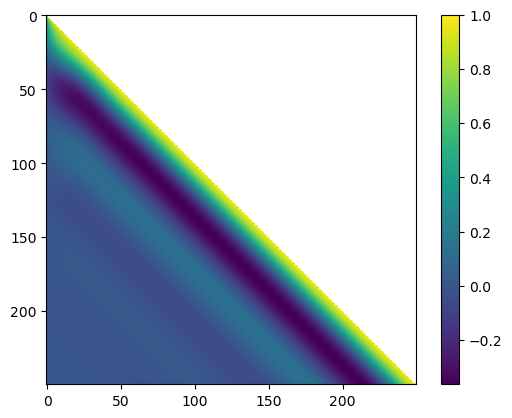

In [9]:
plt.imshow(w_tt)
plt.colorbar()

In [10]:
def p_xx(x,xs):
    return (
        1/np.sqrt(4*np.pi**2*var[:,None]*var[None,:]*(1-w_tt**2)) * np.exp(
            -1/(2*(1-w_tt**2))* ( (x/np.sqrt(var[:,None]))**2 +  (xs/np.sqrt(var[None,:]))**2
            -2 * w_tt* (x/np.sqrt(var[:,None])) *  (xs/np.sqrt(var[None,:])))
        )
    )
#p_xx = np.vectorize(p_xx)

/tmp/ipykernel_4897/742275008.py:3: RuntimeWarning: invalid value encountered in sqrt
  1/np.sqrt(4*np.pi**2*var[:,None]*var[None,:]*(1-w_tt**2)) * np.exp(
/tmp/ipykernel_4897/742275008.py:3: RuntimeWarning: divide by zero encountered in divide
  1/np.sqrt(4*np.pi**2*var[:,None]*var[None,:]*(1-w_tt**2)) * np.exp(
/tmp/ipykernel_4897/742275008.py:4: RuntimeWarning: divide by zero encountered in divide
  -1/(2*(1-w_tt**2))* ( (x/np.sqrt(var[:,None]))**2 +  (xs/np.sqrt(var[None,:]))**2
/tmp/ipykernel_4897/742275008.py:3: RuntimeWarning: overflow encountered in exp
  1/np.sqrt(4*np.pi**2*var[:,None]*var[None,:]*(1-w_tt**2)) * np.exp(
/tmp/ipykernel_4897/742275008.py:3: RuntimeWarning: invalid value encountered in multiply
  1/np.sqrt(4*np.pi**2*var[:,None]*var[None,:]*(1-w_tt**2)) * np.exp(
/tmp/ipykernel_4897/742275008.py:4: RuntimeWarning: invalid value encountered in multiply
  -1/(2*(1-w_tt**2))* ( (x/np.sqrt(var[:,None]))**2 +  (xs/np.sqrt(var[None,:]))**2


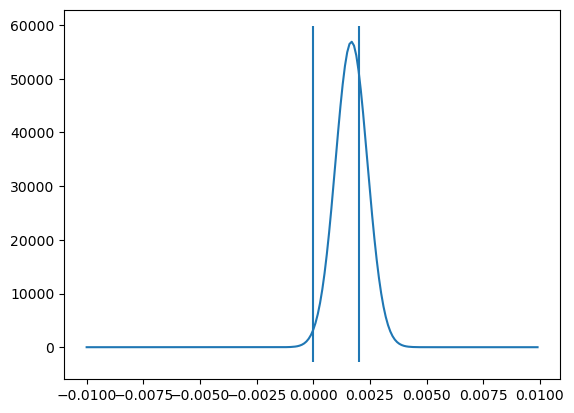

In [11]:
x_s = np.arange(-1e-2,1e-2, dx)
x_0 = 2e-3
cond_x = np.array([p_xx(x_0,this_x)[55,50] for this_x in x_s])
plt.plot(x_s,cond_x)
plt.vlines((0,x_0), *plt.ylim())

In [12]:
np.sum(cond_x)*dx*dx

0.010048327933758861

In [13]:
len(x_s)

200

## Used for time delayed calc

In [4]:
myfpc = FokkerPlankCalculator()
class cond_prob_solver():
    def __init__(self,max_t,dt,x_range, dx,tau,k,D):
        self.t_s = np.arange(0,max_t+dt/2,dt)
        self.x_s = np.arange(x_range[0],x_range[1]+dx/2,dx)
        self.N_x = len(self.x_s)
        self.N_t = len(self.t_s)

        ntau = int(tau/dt)
        self.ntau = ntau

        print(self.N_t,self.N_x, ntau)

        self.l_data = myfpc.l(k, tau,self.t_s)
        self.var = 2*D*np.cumsum(self.l_data**2) *dt

        self.w_ttau = (2*D / np.sqrt(self.var[ntau:]*self.var[:-ntau]) 
            *dt*np.stack( [np.sum( (self.l_data[ntau:t_idx]*self.l_data[:t_idx-ntau])) for t_idx in range(ntau,self.N_t)]))

        self.p_xx = (
                1/np.sqrt(4*np.pi**2*self.var[ntau:,None,None]*self.var[:-ntau,None,None]*(1-self.w_ttau[:,None,None]**2)) * np.exp(
                    -1/(2*(1-self.w_ttau[:,None,None]**2))* 
                    ( (self.x_s[None,:,None]/np.sqrt(self.var[ntau:,None,None]))**2 +  (self.x_s[None,None,:]/np.sqrt(self.var[:-ntau,None,None]))**2
                    -2 * self.w_ttau[:,None,None]* ( (self.x_s[None,:,None]/np.sqrt(self.var[ntau:,None,None])) * (self.x_s[None,None,:]/np.sqrt(self.var[:-ntau,None,None]))))
                )
            )
        self.p_x = self.p_xx.sum(axis = 2)
        self.cp = self.p_xx/self.p_x[:,:,None]

        self.cond_mean = np.zeros((self.N_t, self.N_x))
        self.cond_mean[ntau:] = self.cp@self.x_s
        
        
class mySim():
    def __init__(self,max_t,dt,x_range, dx,tau,k,D, num_particle):
        self.bins = np.arange(x_range[0]-dx/2, x_range[1]+dx/2+dx/2,dx)
        ntau = int(tau/dt)
        self.ntau = ntau
        self.x_s = np.arange(x_range[0],x_range[1]+dx/2,dx)

        if boundary == 'reflective':
            self.pos = get_pos(
                    num_particle=num_particle,
                    max_t = max_t+tau,
                    dt = dt,
                    tau=tau,
                    k=k,
                    D=D,
                    F=lambda t:0)[ntau:]
        elif boundary == 'absorbing':
            self.pos = get_pos_with_border(
                    border = x_range[1]-dx/2,
                    num_particle=num_particle,
                    max_t = max_t+tau,
                    dt = dt,
                    tau=tau,
                    k=k,
                    D=D,
                    F=lambda t:0)[ntau:]

        self.hists = np.stack([np.histogram(o, bins=self.bins)[0]/num_particle*1/dx for o in self.pos])
        self.sim_num_particle = (~self.pos.isnan()).sum(axis=1)
        self.raw_rate = np.diff(self.sim_num_particle, axis = 0) / dt
        self.sim_kappa = -self.raw_rate/self.sim_num_particle[1:]
        
    def compute_cond_measures(self, idx):
        self.sim_var = np.nanvar(self.pos, axis = 1)

        def get_realisations_through_point(pos,t_idx,x_idx):
            x_f, x_t = self.x_s[x_idx]-1/2*dx, self.x_s[x_idx]+1/2*dx
            my_filter = (pos[t_idx] > x_f) * (pos[t_idx] < x_t)
            return pos[:,my_filter]


        filter_x_idxs = np.arange(0,len(self.x_s),1)
        self.pos_filtered = [get_realisations_through_point(self.pos,idx,x_idx) for x_idx in filter_x_idxs]
        self.hists_filterd = np.stack([np.histogram(data[idx-ntau], bins=self.bins)[0]/data.shape[1]*1/dx for data in self.pos_filtered])
        self.hists_filterd = self.hists_filterd/self.hists_filterd.sum(axis=1)[:,None]

        self.mean_filterd = np.stack([data[idx-ntau].mean() for data in self.pos_filtered])
        
class num_methode():
    def __init__(self,D, dx,dt, cond_prob_res):
        N_t = cond_prob_res.N_t
        N_x = cond_prob_res.N_x
        x_s = cond_prob_res.x_s
        cond_mean = cond_prob_res.cond_mean
        #p_xx = cond_prob_res.p_xx
        #self.cp = cond_prob_res.p_xx/cond_prob_res.p_x[:,:,None]
        
        #self.cond_mean[ntau:] = self.cp@self.x_s
        
        R = np.zeros((N_t, N_x, N_x))
        self.data = np.zeros((N_t, N_x))
        self.data[0,np.argmin(x_s**2)] = 1/dx
        

        self.F = -k * cond_mean
        Fm = (self.F[:,1:]+self.F[:,:-1])/2
        rip = D / dx**2 * np.exp((Fm*dx/D)/2)  # r_i->i+1
        rim = D / dx**2 * np.exp(-(Fm*dx/D)/2)  # r_i+1->i
        if boundary == 'reflective':
            R[:,0,0] = -rip[:,0]
            R[:,-1,-1] = -rim[:,-1]
            R[:,np.arange(1,N_x-1),np.arange(1,N_x-1)] = -(rip[:,1:]+rim[:,:-1]) # -(r_i->i+1 + r_i->i-1) ????
            R[:,np.arange(0,N_x-1),np.arange(1,N_x)] = rim
            R[:,np.arange(1,N_x),np.arange(0,N_x-1)] = rip
        elif boundary == 'absorbing':
            R[:,0,0] = -rip[:,0]
            R[:,-1,-1] = -rim[:,-1]
            R[:,np.arange(1,N_x-1),np.arange(1,N_x-1)] = -(rip[:,1:]+rim[:,:-1]) # -(r_i->i+1 + r_i->i-1) ????
            R[:,np.arange(0,N_x-1),np.arange(1,N_x)] = rim[:]
            R[:,np.arange(1,N_x-1),np.arange(0,N_x-2)] = rip[:,:-1]

        self.prop = np.stack([expm(o*dt) for o in R])

        for i in range(1,len(self.prop)):
            self.data[i] = self.prop[i-1]@self.data[i-1]

        mx = (self.data/self.data.sum(axis = 1)[:,None])@x_s
        mx2 = (self.data/self.data.sum(axis = 1)[:,None])@ x_s**2
        self.variants = mx2-mx**2

        self.suv_prob = self.data.sum(1)
        self.num_kappa = -np.diff(self.suv_prob)/self.suv_prob[1:]/dt

## One case

In [5]:
max_t = 4
#avarage = 100
x_range = (-4e-3,2e-3)
dx = 0.00004*2
tau = 0.2# 0.2#0.01#0.25 #0.3 #0.1 #0.05#0.1
D = 1e-6
k = 3
dt = 1e-3 *2


F_ext = lambda t:0

cpr = cond_prob_solver(max_t,dt,x_range, dx,tau,k,D)

boundary =    'absorbing' #'reflective'
1/np.e /k, np.pi/2 /k

2001 76 100


(0.12262648039048078, 0.5235987755982988)

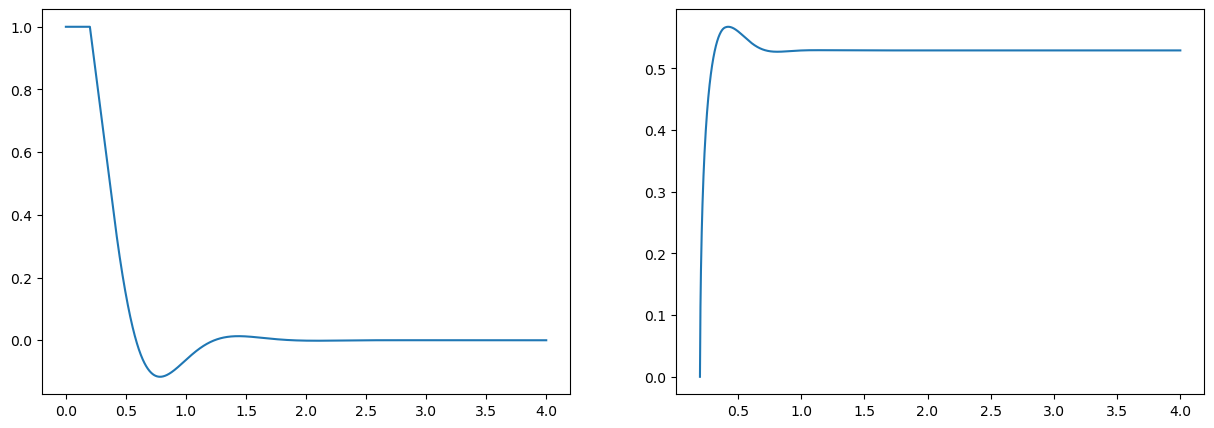

In [6]:
slop = np.mean((cpr.cond_mean[:,1:]-cpr.cond_mean[:,:-1])/dx,1)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(cpr.t_s,cpr.l_data)
plt.subplot(122)
plt.plot(cpr.t_s[cpr.ntau:],cpr.w_ttau)

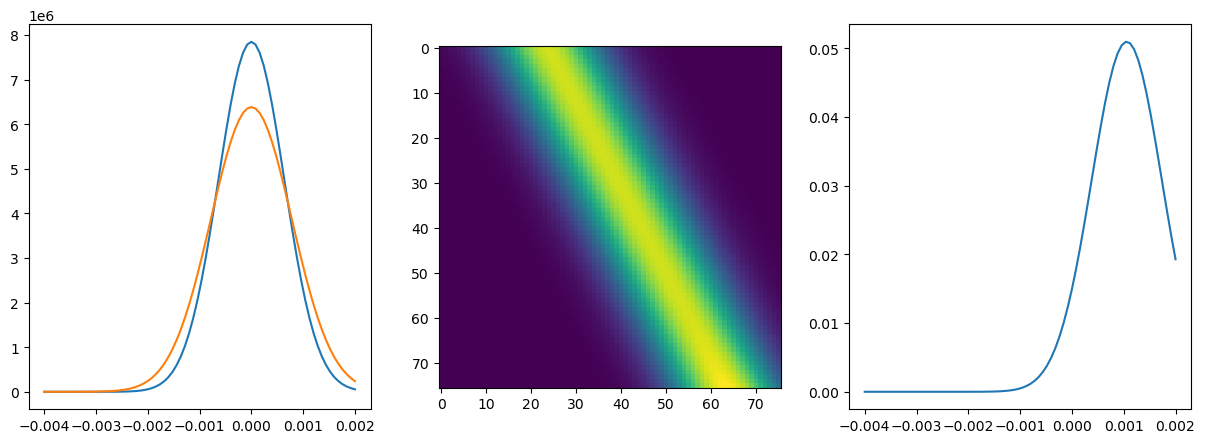

In [7]:
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.plot(cpr.x_s,cpr.p_x[0])
plt.plot(cpr.x_s,cpr.p_x[100])

plt.subplot(132)
plt.imshow(cpr.cp[300])

plt.subplot(133)
#plt.plot(x_s,cp[100,10])
plt.plot(cpr.x_s,cpr.cp[800,-1])

In [8]:
num_particle = 20_000
ntau = int(tau/dt)
idx = 600 + ntau
sr = mySim(max_t,dt,x_range, dx,tau,k,D, num_particle)
sr.compute_cond_measures(idx)

100


/tmp/ipykernel_13239/1689404148.py:77: RuntimeWarning: invalid value encountered in divide
  self.hists_filterd = np.stack([np.histogram(data[idx-ntau], bins=self.bins)[0]/data.shape[1]*1/dx for data in self.pos_filtered])


In [9]:
len(sr.pos_filtered)

76

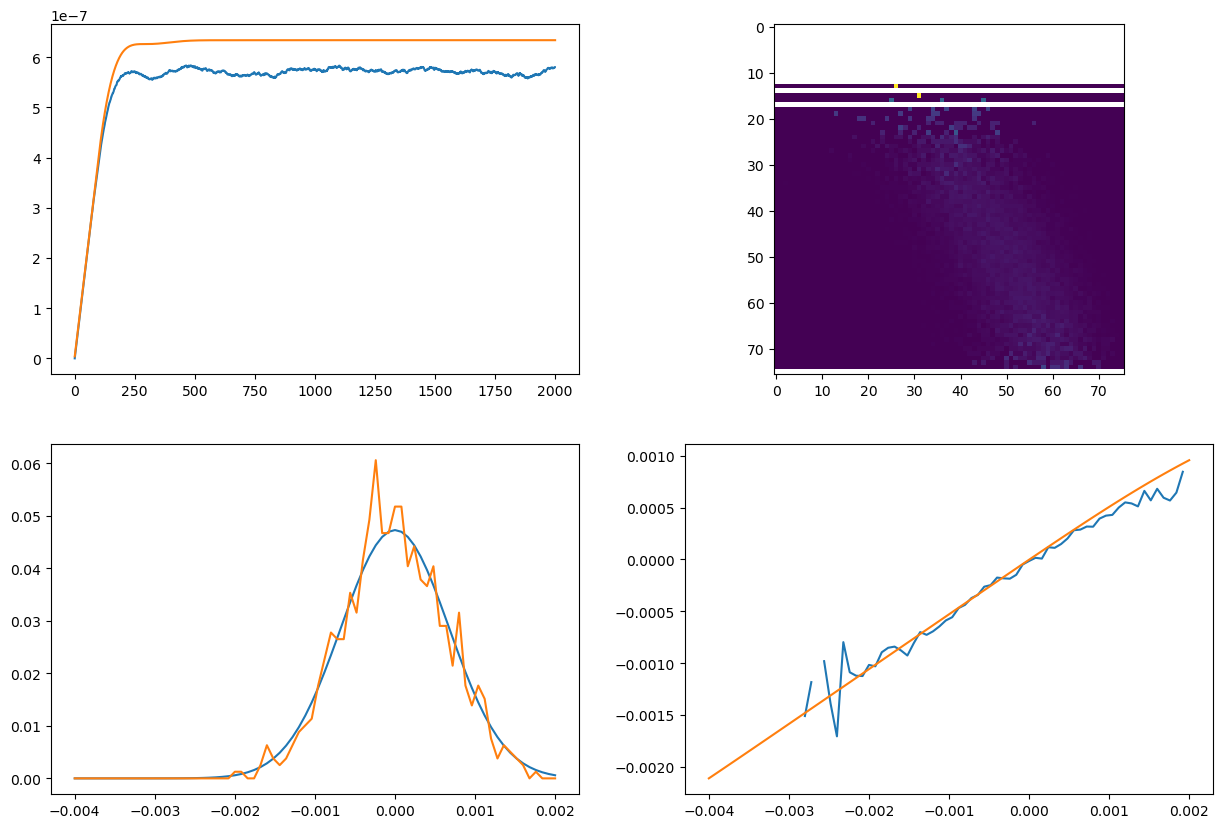

In [14]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(sr.sim_var)
plt.plot(cpr.var)

plt.subplot(222)
plt.imshow(sr.hists_filterd)

plt.subplot(223)
sidx = 50
plt.plot(cpr.x_s,cpr.cp[idx-ntau][sidx])
plt.plot(sr.x_s,sr.hists_filterd[sidx])

plt.subplot(224)
plt.plot(sr.x_s,sr.mean_filterd)
plt.plot(cpr.x_s,cpr.cond_mean[idx])

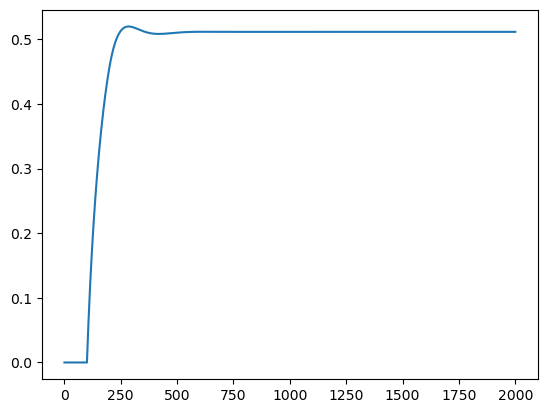

In [15]:
plt.plot(slop)

In [23]:
nr = num_methode(D, dx,dt, cpr)

0.09432522536371835
0.06389720253736558


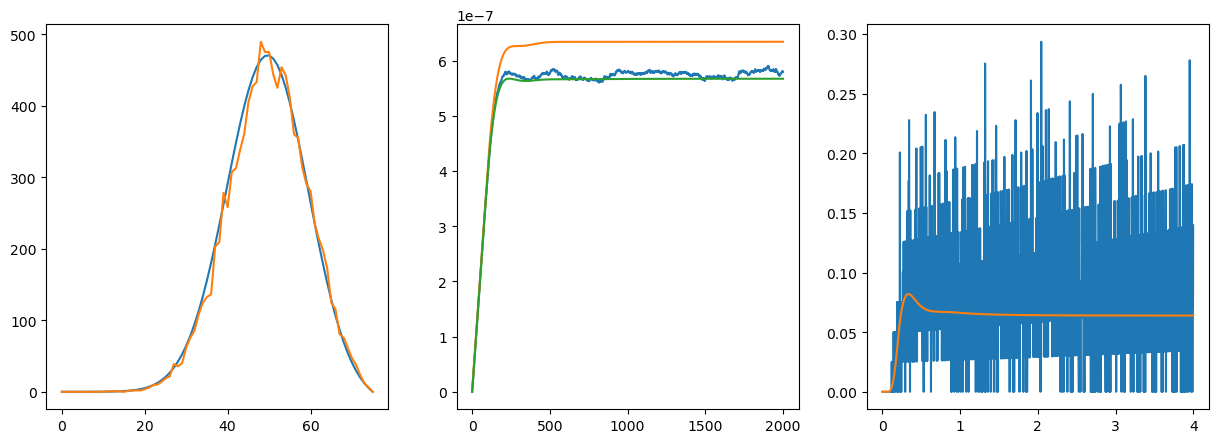

In [24]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(nr.data[800])
plt.plot(sr.hists[800])

plt.subplot(132)
plt.plot(sr.sim_var)
plt.plot(cpr.var)
plt.plot(nr.variants)

plt.subplot(133)
plt.plot(cpr.t_s[1:-1],sr.sim_kappa)
plt.plot(cpr.t_s[1:],nr.num_kappa)

print(np.mean(sr.sim_kappa[-100:].numpy()))
print(np.mean(nr.num_kappa[-100:]))

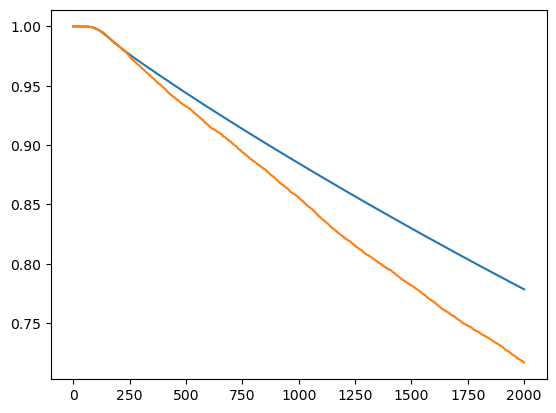

In [25]:
plt.plot(nr.suv_prob/nr.suv_prob[0])
plt.plot(sr.sim_num_particle/sr.sim_num_particle[0])

## Kappa of tau curve

In [3]:
max_t = 4
#avarage = 100
x_range = (-4e-3,2e-3)
dx = 0.00004
D = 1e-6
k = 3
dt = 1e-3 * 4


F_ext = lambda t:0

boundary =   'absorbing' #'reflective'

taus = np.arange(dt*10,0.6,dt*10)

In [4]:
rates = np.empty_like(taus)
for i,l_tau in tqdm(enumerate(taus)):
    l_cpr = cond_prob_solver(max_t,dt,x_range, dx,l_tau,k,D)
    l_nr = num_methode(D, dx,dt, l_cpr)
    rates[i] = np.mean(l_nr.num_kappa[-40:])

0it [00:00, ?it/s]

1001 151 10
1001 151 20
1001 151 30
1001 151 40
1001 151 50
1001 151 60
1001 151 69
1001 151 80
1001 151 90
1001 151 99
1001 151 110
1001 151 120
1001 151 130
1001 151 140


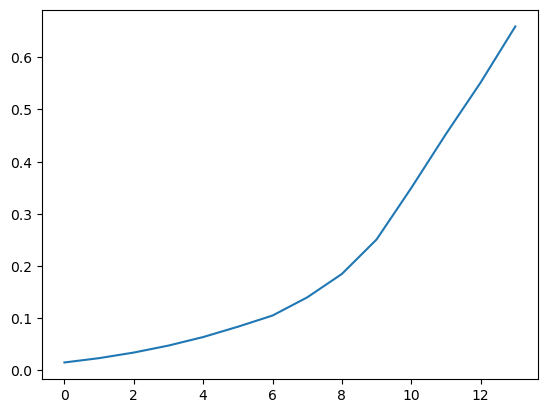

In [5]:
plt.plot(rates)

In [8]:
num_particle = 100_000
sim_rates = np.empty_like(taus)
for i,l_tau in tqdm(enumerate(taus)):
    sr = mySim(max_t,dt,x_range, dx,l_tau,k,D, num_particle)
    sim_rates[i] = np.mean(sr.sim_kappa[-40:].numpy())

0it [00:00, ?it/s]

10
20
30
40
50
60
69
80
90
99
110
120
130
140


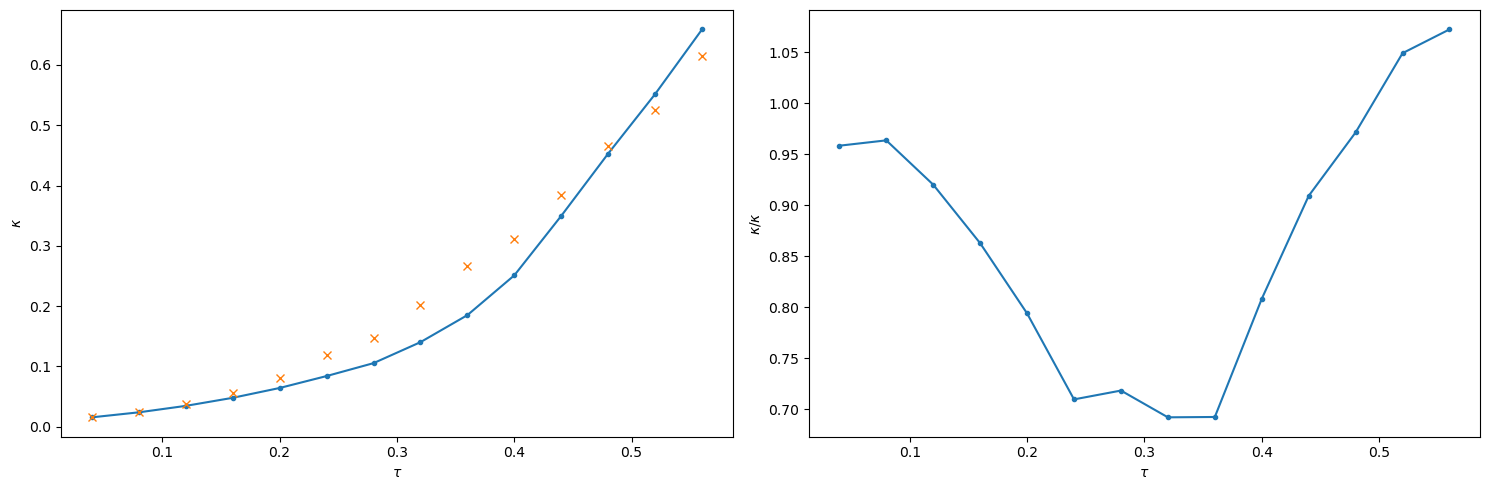

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(taus,rates,'.-')
plt.plot(taus,sim_rates,'x')
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\kappa$")

plt.subplot(122)
plt.plot(taus,rates/sim_rates,'.-')
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\kappa / \kappa$")
plt.tight_layout()
plt.savefig('Graphic_Results/kappa_tau_cond_prob.pdf')